In [1]:
from utils.models import isoelastic_utility, IsoelasticWealthChange

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.size"] = 15

### Isoelastic utility function

$u(x)=\frac{x^{1-\eta}-1}{1-\eta}$

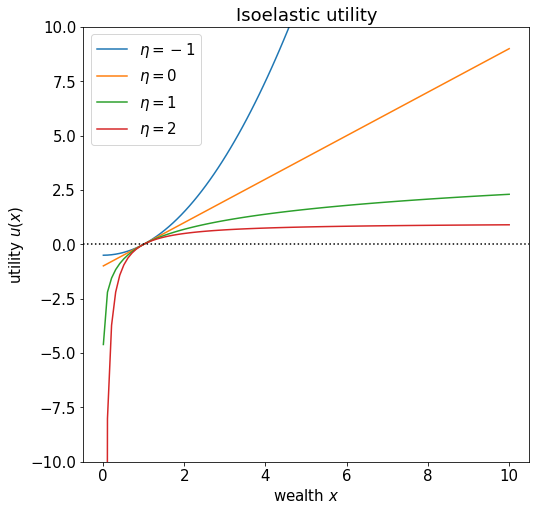

In [2]:
fig, ax = plt.subplots(figsize=(8, 8))

x = np.linspace(0.01, 10, 100)

for eta in (-1, 0, 1, 2):
    y = isoelastic_utility(x, eta) 
    ax.plot(x, y, label=f"$\eta = {eta}$")

ax.set_ylim([-10, 10])
ax.axhline(0, color="k", linestyle=":")

ax.set_xlabel("wealth $x$")
ax.set_ylabel("utility $u(x)$")
ax.set_title("Isoelastic utility")
ax.legend()

### Wealth dynamics for fixed growth rate

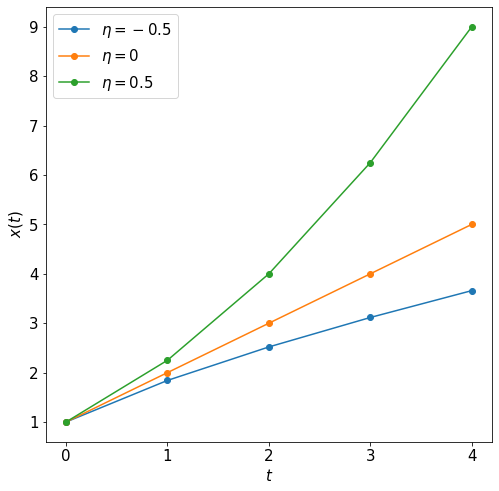

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))

gamma = 1
x0 = 1

for eta in [-0.5, 0, 0.5]:
    f = IsoelasticWealthChange(gamma, eta)
    y = f.evolve_wealth(x0, 5)
    ax.plot(y, "-o", label=r"$\eta" + f"={eta}$")

ax.set_xticks(range(5))
ax.set_xlabel("$t$")
ax.set_ylabel("$x(t)$")
ax.legend()

### Wealth dynamics for different growth rates

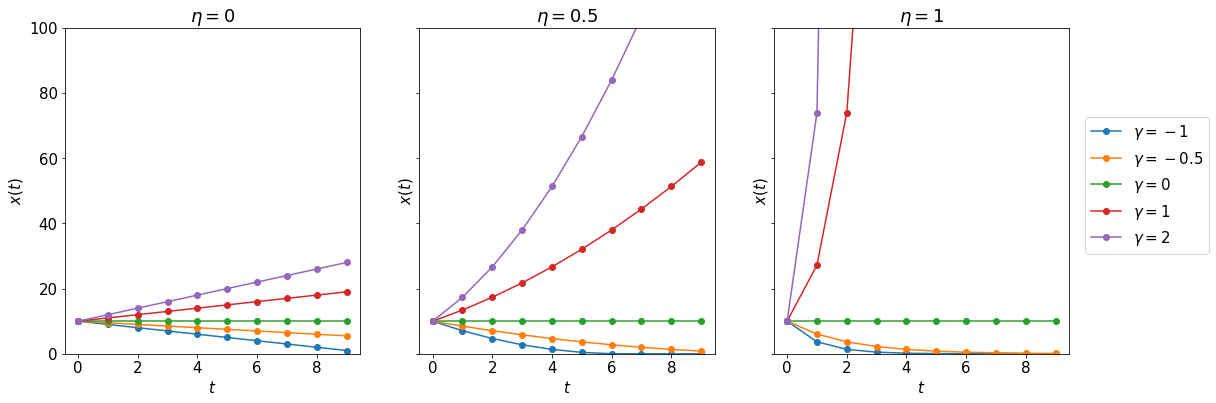

In [4]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=3, sharey=True)

x0 = 10

for i, eta in enumerate([0, 0.5, 1]):
    for gamma in [-1, -0.5, 0, 1, 2]:
        f = IsoelasticWealthChange(gamma, eta)
        y = f.evolve_wealth(x0, 10)
        axs[i].plot(y, "-o", label=f"$\gamma={gamma}$")

    axs[i].set_xlabel("$t$")
    axs[i].set_ylabel("$x(t)$")
    axs[i].set_ylim([0, 100])
    axs[i].set_title(f"$\eta={eta}$")

axs[-1].legend(bbox_to_anchor=(1.5, .75))